# Thickness & Texture

In this notebook we look into **Thickness & Texture**, two shape descriptors, tailored for plan description. Once we have extracted the **skeleton** of a given floor plan's walls, we sample points along the main edges of the skeleton and look for the perpendicular distance from these point to the surface of the wall.

- **Thickness**: to understand wall thickness, we compute the average M of all D values for each wall, and we then print the histogram of all value M. The Average of M values, gives a single descriptor wall thicknesses across the plan, while the histogram describes the distribution of these thicknesses.

- **Texture**: we look into the ornamentation of the walls. To do so, we compute the variation of D values across the plan. This variation V is then reported as a histogram and as an average, to qualify the overall wall surface variation across the plan.


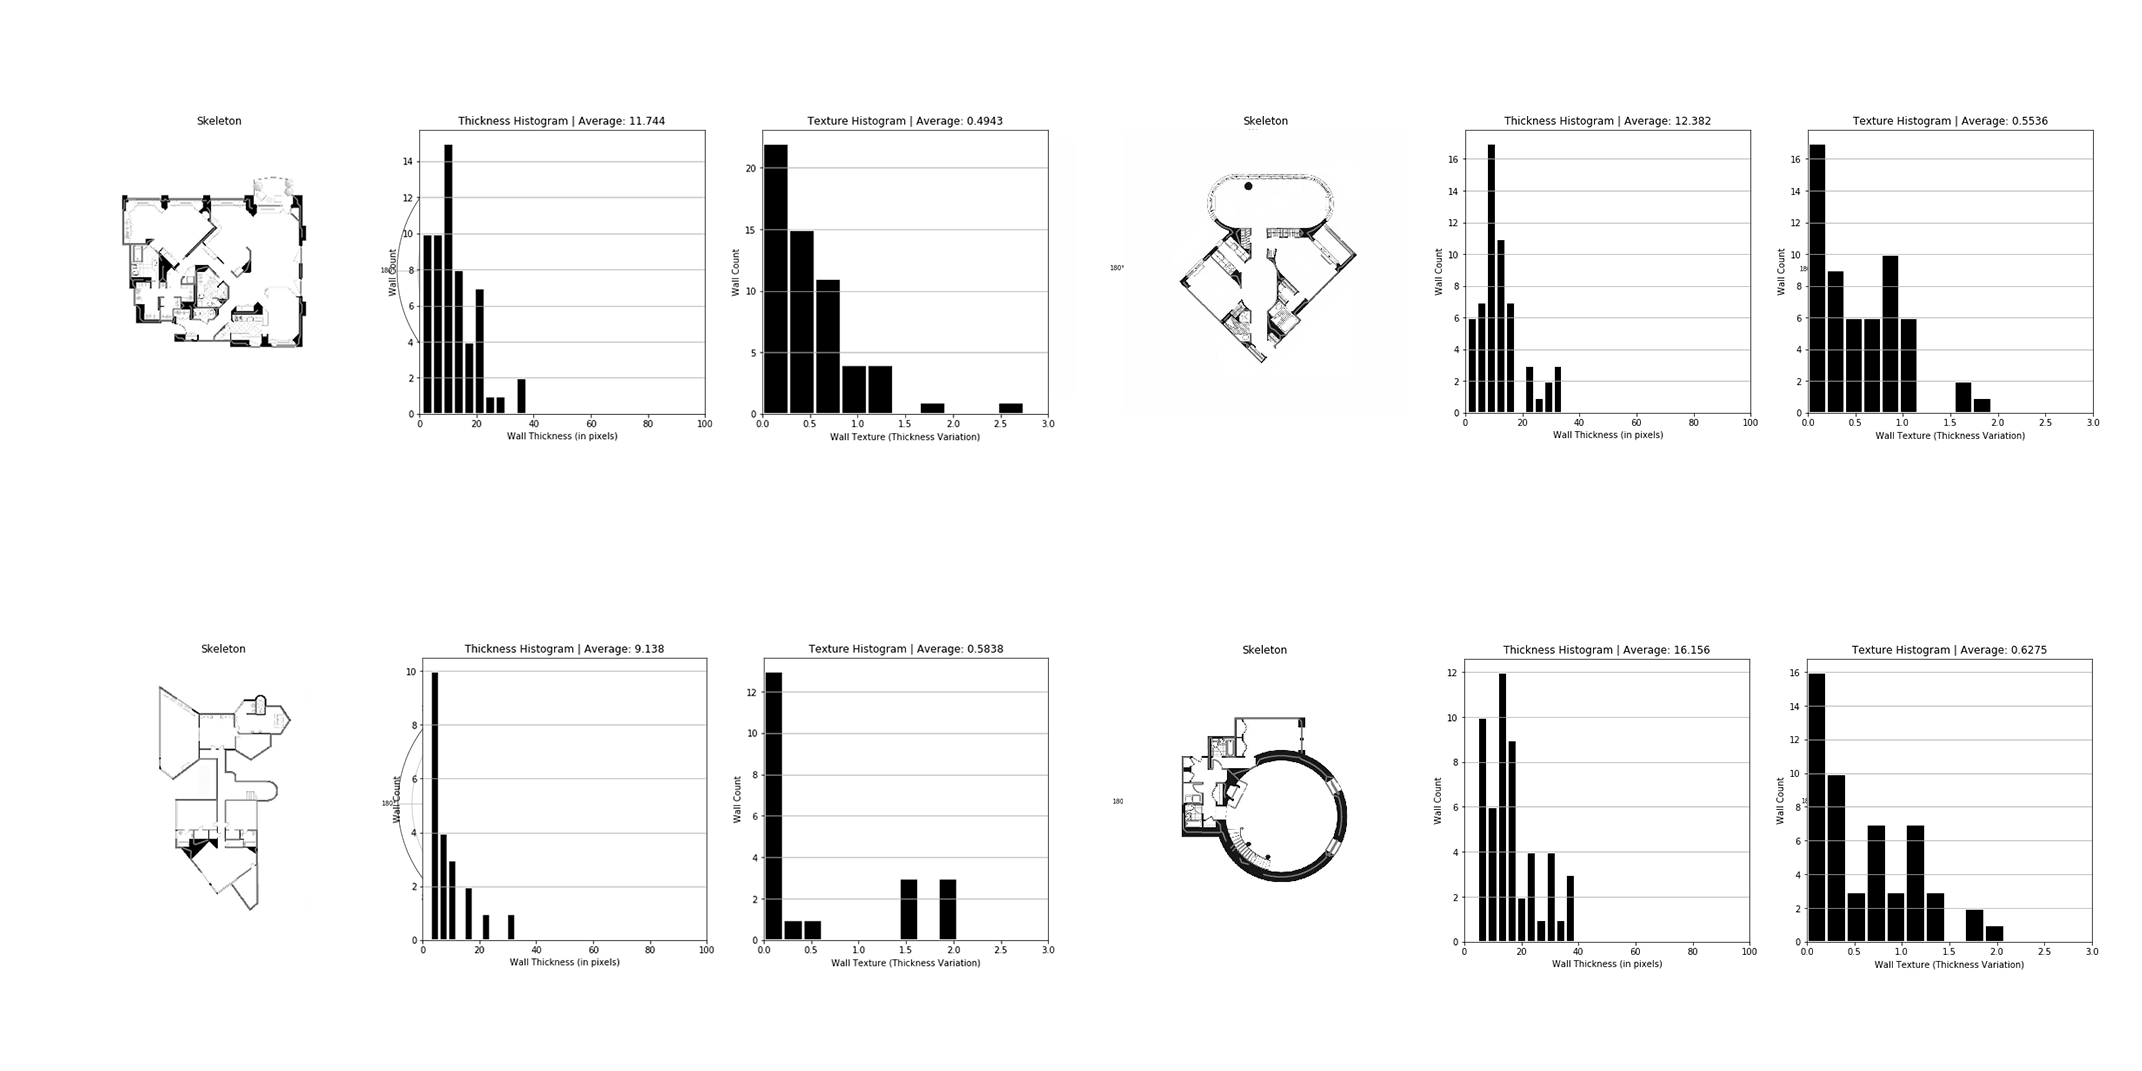

In [9]:
from IPython.display import Image
Image(filename='IMG/thick_text.png',width=1200, height=300)

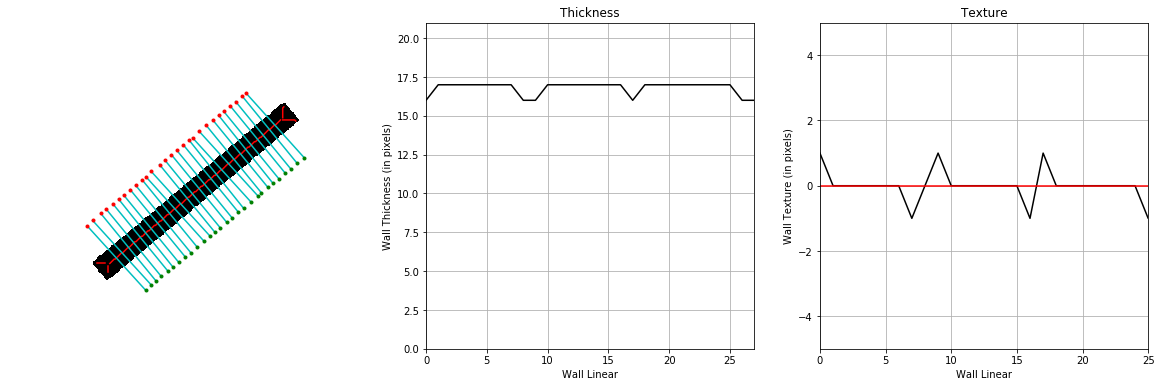

In [7]:
Image(filename='IMG/test/wall analysis.png',width=1200, height=300)

In [4]:
import pandas as pd
import cairo
import matplotlib.pylab as plt
import math
from IPython.display import Image
import numpy as np
from numpy import *
import glob
import os
import os.path
import time
import cv2
import random
import ast
from PIL import Image
from math import *
import networkx as nx
import matplotlib.cm as cm
from matplotlib.pyplot import figure, show, rc
from scipy.ndimage.interpolation import geometric_transform
from skimage.morphology import skeletonize
from skimage import data
import sknw
import random
from shapely.geometry import LineString

### Utility Functions

In [4]:
def get_skeleton(img_2,print_):
    # open and skeletonize
    img = np.abs(np.round(img_2[:,:,0]/255).astype(np.int)-1)
    img_white = np.round(img_2[:,:,0]/255).astype(np.int)
    ske = skeletonize(img).astype(np.uint16)

    # build graph from skeleton
    graph = sknw.build_sknw(ske)

    if(print_==True):
        plt.figure(figsize=(10,10))
        # plt.imshow(img_white, cmap='gray')

    # draw edges by pts
    if(print_==True):
        for (s,e) in graph.edges():
            ps = graph[s][e]['pts']
            plt.plot(ps[:,1], ps[:,0], 'black')


    # draw node by o
    node, nodes = graph.node, graph.nodes()
    
   
    if(print_==True):
        plt.title('Skeleton')
        plt.axis("off")
        plt.show()
    
    return graph, img_white

def get_len(x1,y1,x2,y2):
    length = math.sqrt((x2-x1)**2+(y2-y1)**2)
    return length

In [5]:
def createLineIterator(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])     
    """
    #define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
    itbuffer.fill(np.nan)

    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: #vertical line segment
       itbuffer[:,0] = P1X
       if negY:
           itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
       else:
           itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
    elif P1Y == P2Y: #horizontal line segment
       itbuffer[:,1] = P1Y
       if negX:
           itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
       else:
           itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else: #diagonal line segment
       steepSlope = dYa > dXa
       if steepSlope:
           slope = dX.astype(np.float32)/dY.astype(np.float32)
           if negY:
               itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
           else:
               itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
           itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(np.int) + P1X
       else:
           slope = dY.astype(np.float32)/dX.astype(np.float32)
           if negX:
               itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
           else:
               itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
           itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(np.int) + P1Y

    #Remove points outside of image
    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

    #Get intensities from img ndarray
    itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

    return itbuffer

In [6]:
def wall_analysis(img_path,edge_id):
    
    k=edge_id
    
    img_h69 = cv2.imread(img_path)
    graph_h69, image_h69 = get_skeleton(img_h69,print_=False)

    w,h,d = img_h69.shape

    edges_list_h69 = [graph_h69[s][e]['pts'] for (s,e) in graph_h69.edges()]

    #plt.figure(figsize=(10,10))
    fig = plt.figure(figsize=(20, 6))
    ax1 = fig.add_subplot(131)
    ax1.axis("off")

    # draw edges by pts
    for (s,e) in graph_h69.edges():
        ps = graph_h69[s][e]['pts']
        ax1.plot(ps[:,1], ps[:,0], 'red')

    ######SET PARAMETERS#########
    #############################
    #############################

    #Select edge
    #k = 2
    #number of point to sample
    nb_point = 30
    #radius
    radius= 40

    #############################
    #############################
    #############################

    index_ = np.linspace(0,len(edges_list_h69[k])-1,num=nb_point).astype(int)

    middle_id = int(len(edges_list_h69[k])/2)
    middle_before = middle_id-1
    middle_before = middle_id+1

    x_pt = edges_list_h69[k][middle_id][1]
    y_pt = edges_list_h69[k][middle_id][0]

    padding = 100

    pts= [edges_list_h69[k][j] for j in index_]

    wall_thickness = []
    for i in range(1,len(pts)-1):

        v= pts[i+1]-pts[i-1]
        n = [v[1],-v[0]]

        u = n/np.linalg.norm(n)

        new_pt_1 = pts[i]-radius*u
        new_pt_2 = pts[i]+radius*u

        pixel_values = createLineIterator([new_pt_1[1].astype(int),new_pt_1[0].astype(int)], [new_pt_2[1].astype(int),new_pt_2[0].astype(int)], image_h69).astype(int)
        wall_thick = np.sum(pixel_values[:,2]!=1)

        wall_thickness.append(wall_thick)

        ax1.plot([new_pt_1[1],new_pt_2[1]],[new_pt_1[0],new_pt_2[0]],"c")  
        ax1.plot(new_pt_2[1],new_pt_2[0],"r.")
        ax1.plot(new_pt_1[1],new_pt_1[0],"g.")

    ax1.imshow(image_h69, cmap='gray')

    ax2 = fig.add_subplot(132)
    ax2.plot(wall_thickness,"black")
    ax2.set_title("Thickness")
    ax2.set_xlabel("Wall Linear")
    ax2.set_ylabel("Wall Thickness (in pixels)")
    ax2.set_ylim([0,np.max(wall_thickness)+4])
    ax2.set_xlim([0,len(wall_thickness)-1])
    plt.grid()

    delta_thick = []
    for i in range(1,len(wall_thickness)):
        delta = (wall_thickness[i]-wall_thickness[i-1])
        delta_thick.append(delta)

    ax3 = fig.add_subplot(133)
    ax3.plot(delta_thick,"black")
    ax3.set_title("Texture")
    ax3.plot([len(wall_thickness)-3,0],[0,0],"r")
    ax3.set_xlabel("Wall Linear")
    ax3.set_ylabel("Wall Texture (in pixels)")
    ax3.set_ylim([-5,5])
    ax3.set_xlim([0,len(wall_thickness)-3])
    plt.grid()

### Application

#### Wall Analysis

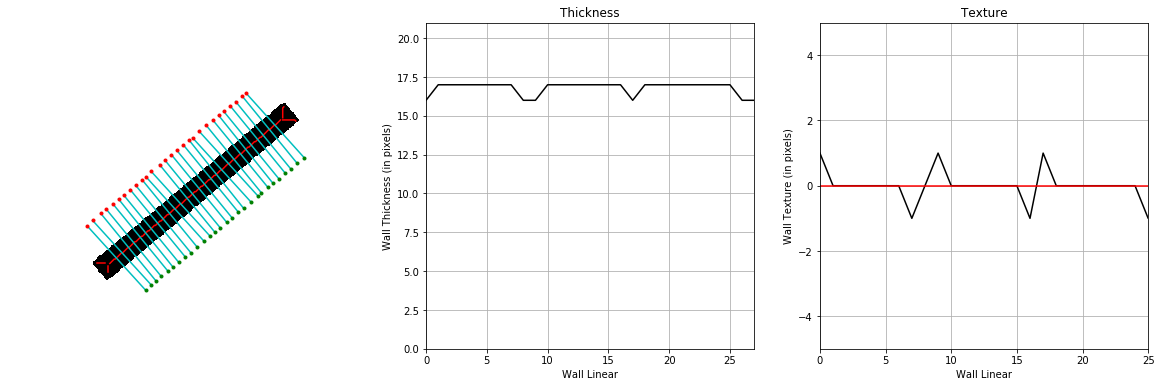

In [7]:
img_path = "IMG/test/8.PNG"
wall_analysis(img_path,edge_id=2)

#### Plan Analysis

In [8]:
img_names = os.listdir("IMG/crazy_plans/clean")
img_path = "IMG/crazy_plans/clean/"+img_names[0]

In [9]:
def thick_texture(img_path):
    
    ## GET SKELETON ###################
    ##################################
    im = cv2.imread(img_path)
    graph_, image_ = get_skeleton(im,print_=False) 
    
    ## FILTER EDGES ##################
    #################################

    edges_list = [graph_[s][e]['pts'] for (s,e) in graph_.edges()]
    e_l = np.array(edges_list)

    edges = []
    lengths = []
    for j in range(len(e_l)):
        #get start and end point of edge
        x_start = e_l[j][:,0][0]
        y_start = e_l[j][:,1][0]
        x_end = e_l[j][:,0][-1]
        y_end = e_l[j][:,1][-1]

        length = get_len(x_start,y_start,x_end,y_end)
        lengths.append(length)
        edges.append(e_l[j])

    filtered_edges = np.array(edges)[lengths > np.std(lengths)]

    ## ANALYSE EDGES ###########################
    ###########################################
    #set edge list
    edges_list_h69 = filtered_edges

    #initialize tecture and thickness arrays
    texture = []
    thickness = []

    for k in range(len(filtered_edges)):

        #number of point to sample
        nb_point = 30
        #radius
        radius= 40

        index_ = np.linspace(0,len(edges_list_h69[k])-1,num=nb_point).astype(int)

        pts= [edges_list_h69[k][j] for j in index_]

        ## THICKNESS ------------------------------------------------------------------
        wall_thickness = []
        for i in range(1,len(pts)-1):

            v= pts[i+1]-pts[i-1]
            n = [v[1],-v[0]]

            u = n/np.linalg.norm(n)

            new_pt_1 = pts[i]-radius*u
            new_pt_2 = pts[i]+radius*u

            pixel_values = createLineIterator([new_pt_1[1].astype(int),new_pt_1[0].astype(int)], [new_pt_2[1].astype(int),new_pt_2[0].astype(int)], image_).astype(int)
            wall_thick = np.sum(pixel_values[:,2]!=1)

            wall_thickness.append(wall_thick)

        thickness.append(np.mean(wall_thickness))

        ## TEXTURE ------------------------------------------------------------------
        delta_thick = []
        for i in range(1,len(wall_thickness)):
            delta = (wall_thickness[i]-wall_thickness[i-1])
            delta_thick.append(delta)

        texture.append(np.mean(delta_thick))
        
    return np.array(thickness), np.array(texture) , filtered_edges

In [10]:
def get_thickness_texture(img_path):
    #img_path  ="IMG/test/baroque.jpg"
    thickness, texture , edges= thick_texture(img_path)

    fig = plt.figure(figsize=(20, 6))

    ax1 = fig.add_subplot(131)
    ax1.imshow(cv2.imread(img_path),cmap="Greys")
    for edge in edges:
        ax1.plot(edge[:,1], edge[:,0], 'red')
    ax1.axis("off")
    ax1.set_title("Skeleton")

    ax2 = fig.add_subplot(132)
    ax2.hist(thickness, color="black",edgecolor='white',linewidth=3)
    ax2.set_xlim([0,100])
    ax2.set_title("Thickness Histogram | Average: "+str( np.around(np.mean(thickness),decimals=3) ))
    ax2.set_xlabel("Wall Thickness (in pixels)")
    ax2.set_ylabel("Wall Count")
    ax2.yaxis.grid()

    ax3 = fig.add_subplot(133)
    ax3.hist(np.abs(texture), color="black",edgecolor='white',linewidth=3)
    ax3.set_xlim([0,3])
    ax3.set_title("Texture Histogram | Average: "+str( np.around(np.mean(np.abs(texture)),decimals=4) ))
    ax3.set_xlabel("Wall Texture (Thickness Variation)")
    ax3.set_ylabel("Wall Count")
    ax3.yaxis.grid()
    #ax3.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')

    plt.show()

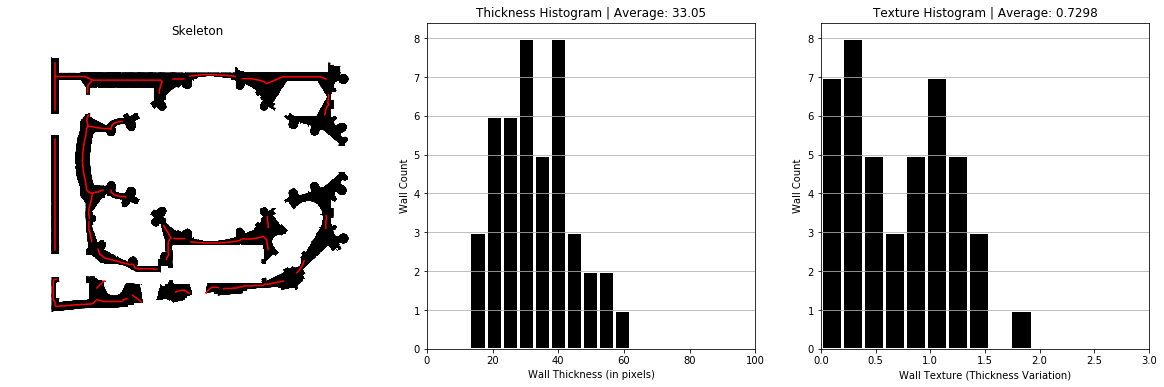

In [11]:
get_thickness_texture("IMG/test/baroque.jpg")

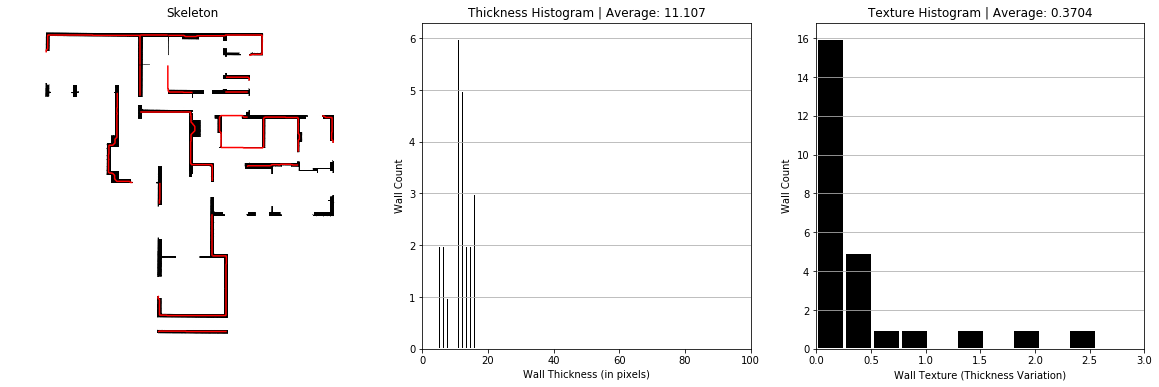

In [12]:
get_thickness_texture("IMG/test/mies.jpg")

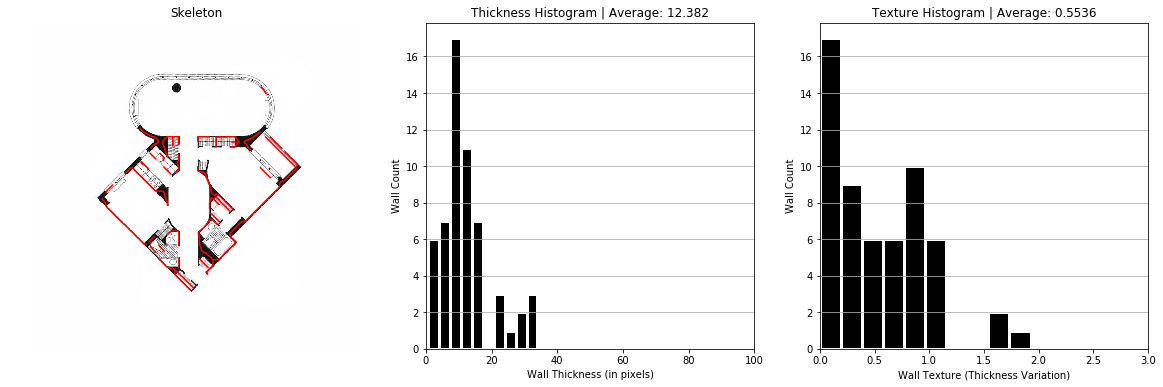

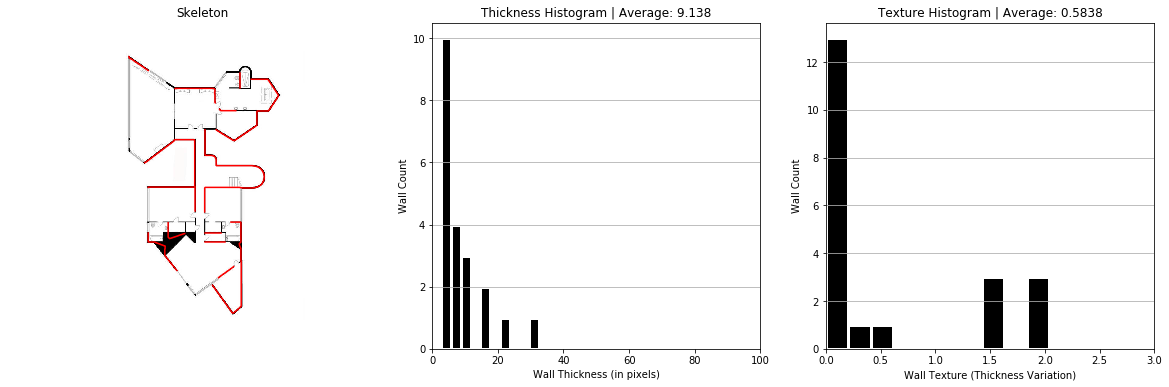

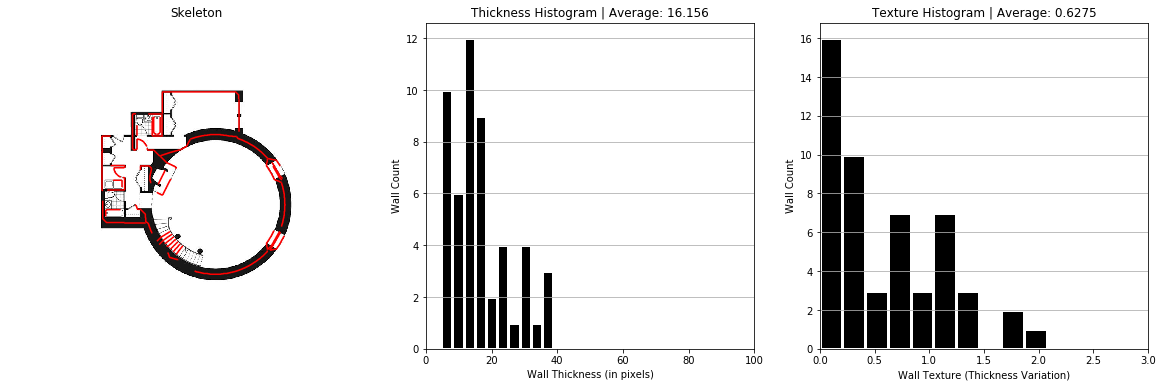

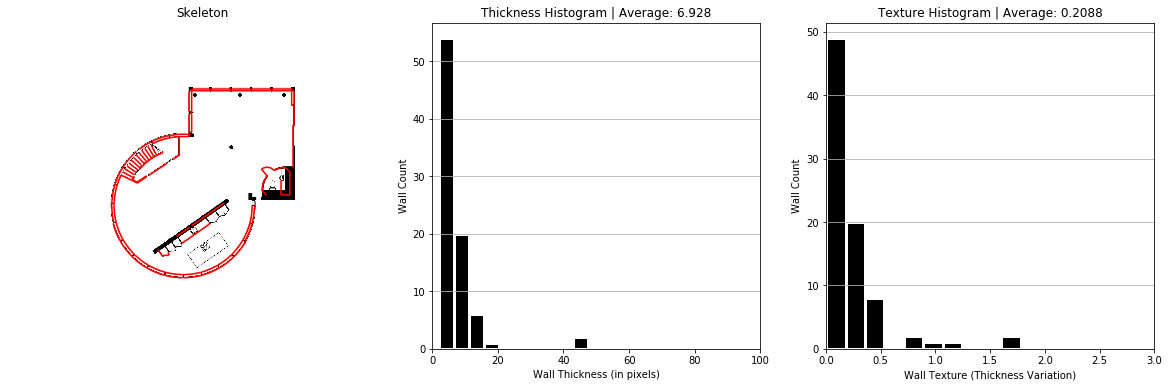

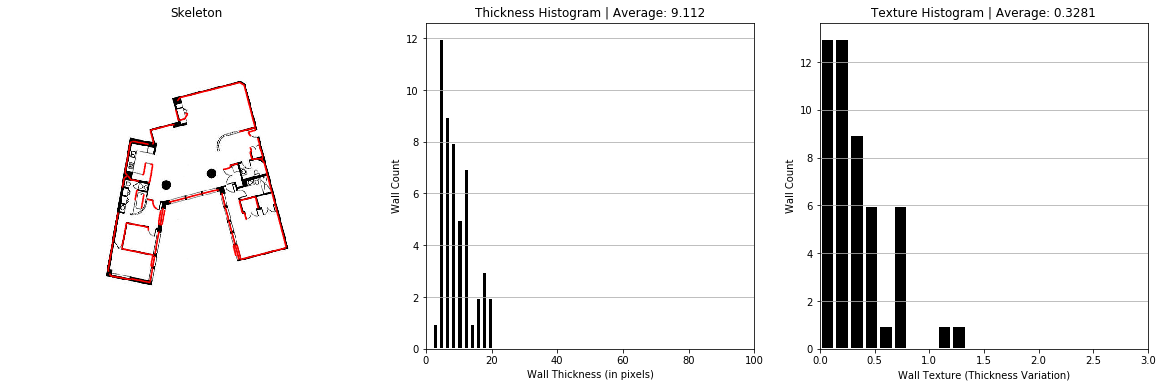

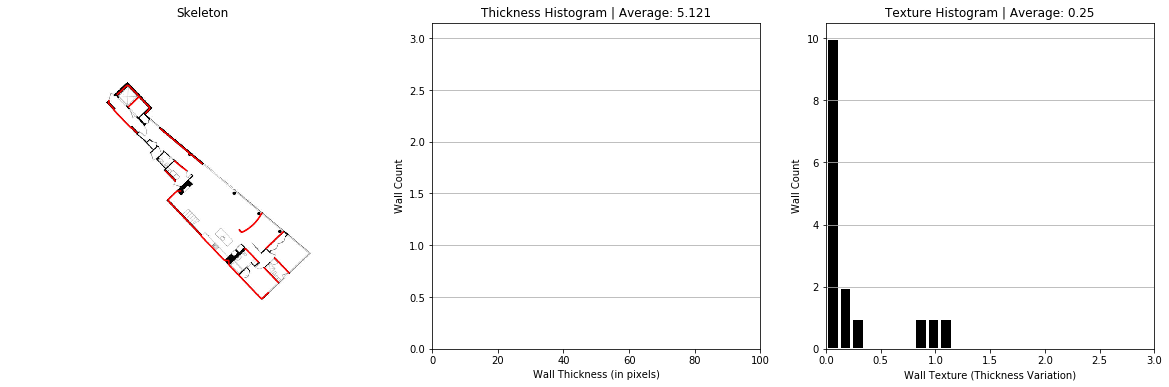

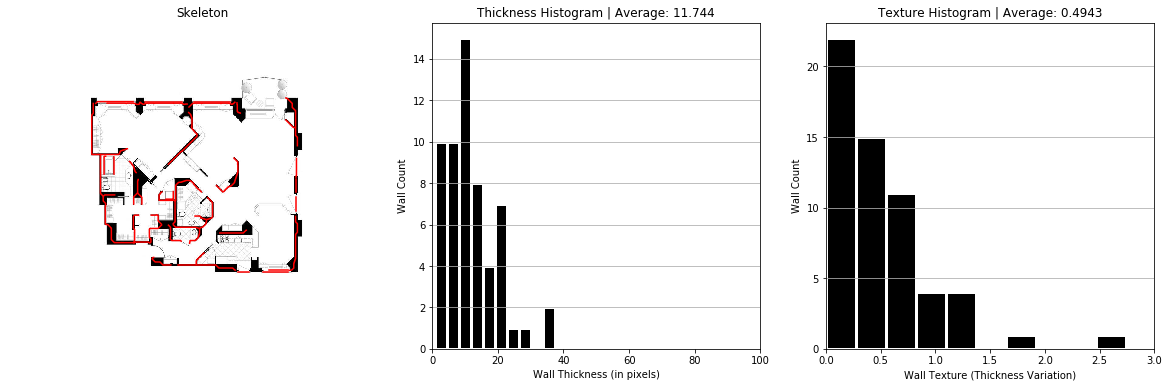

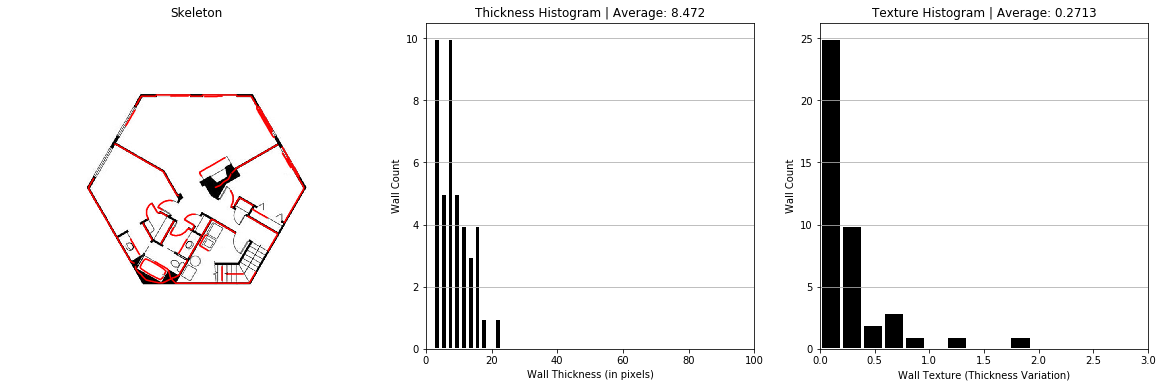

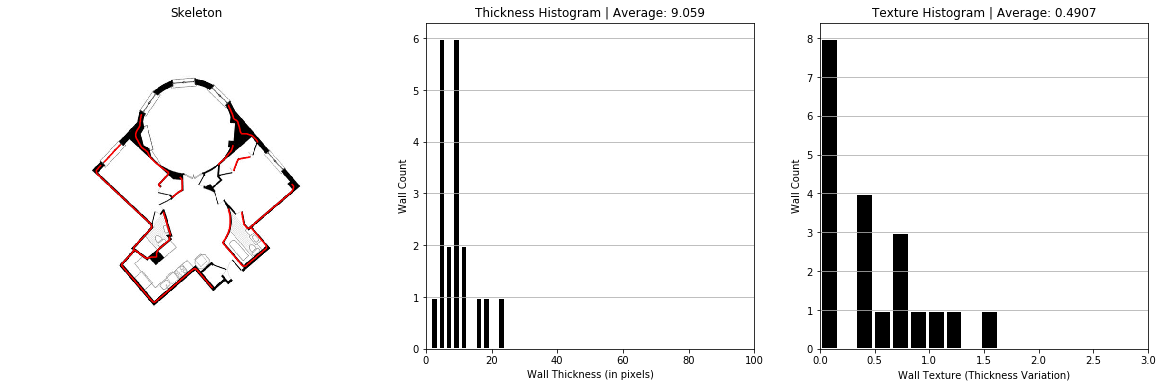

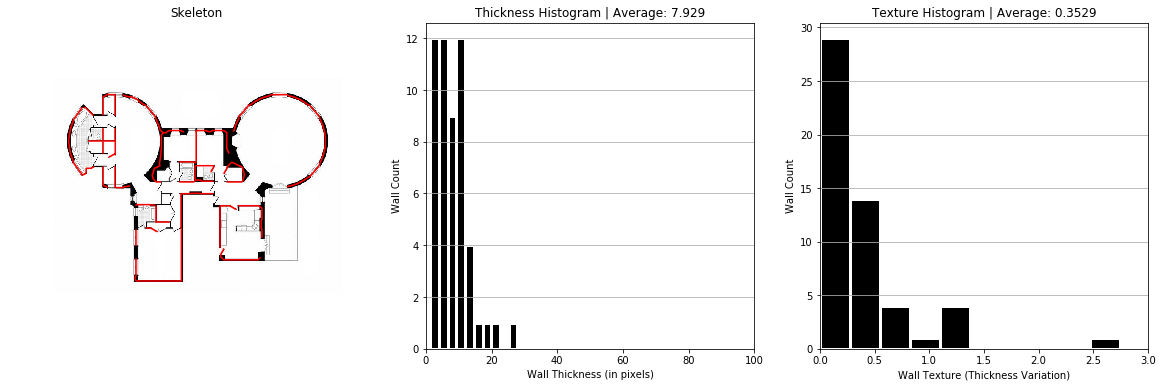

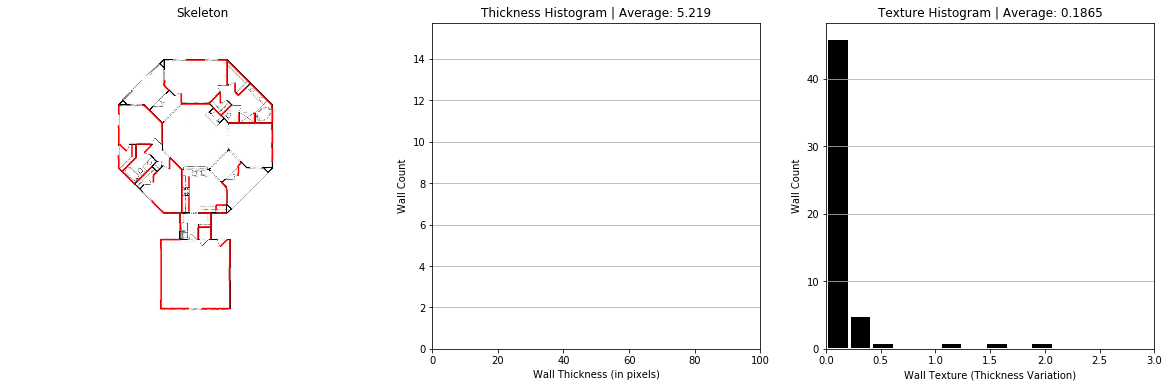

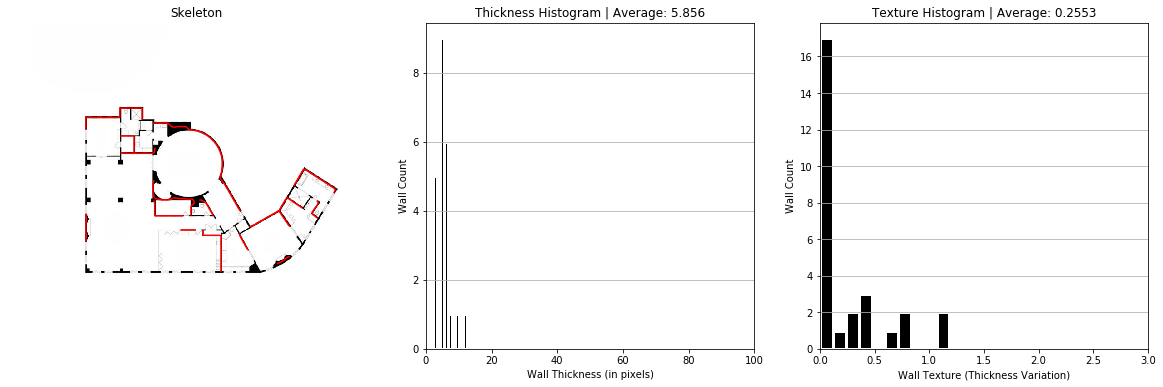

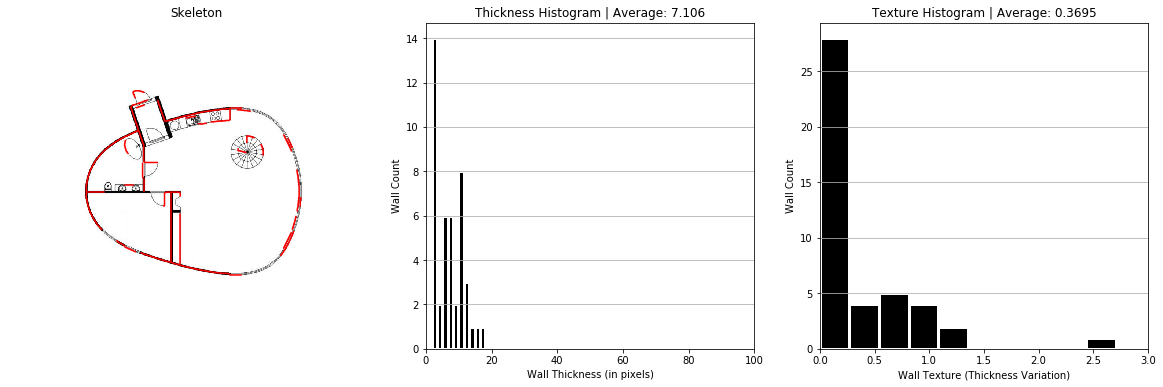

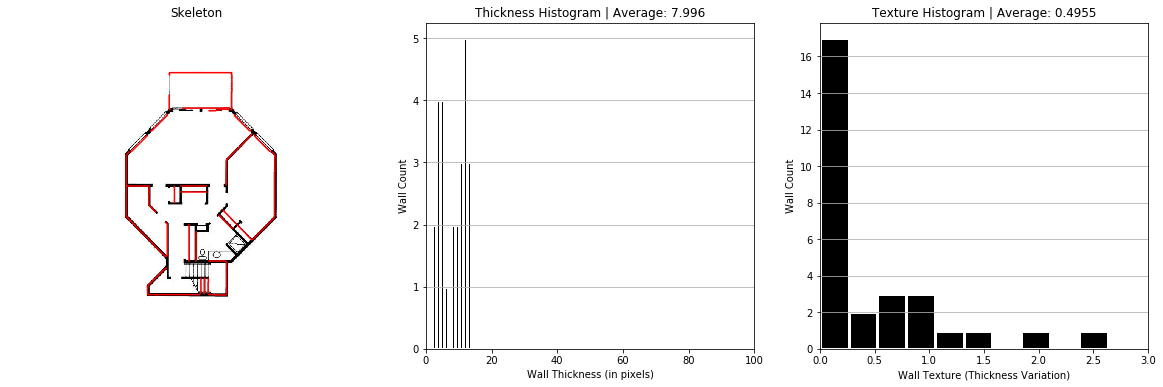

C:\Users\TempUser\Anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


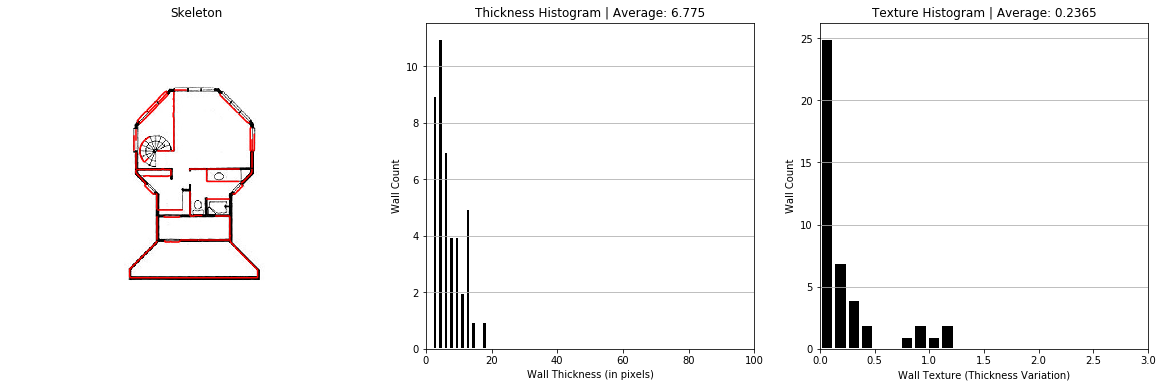

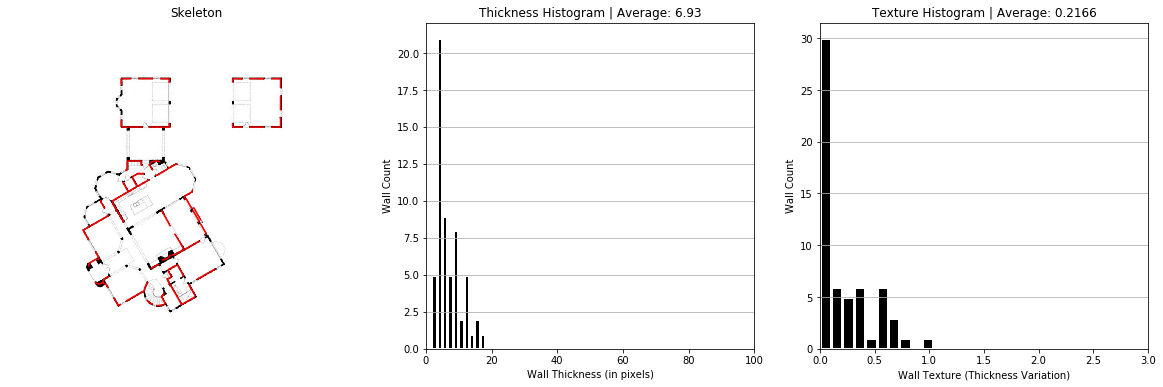

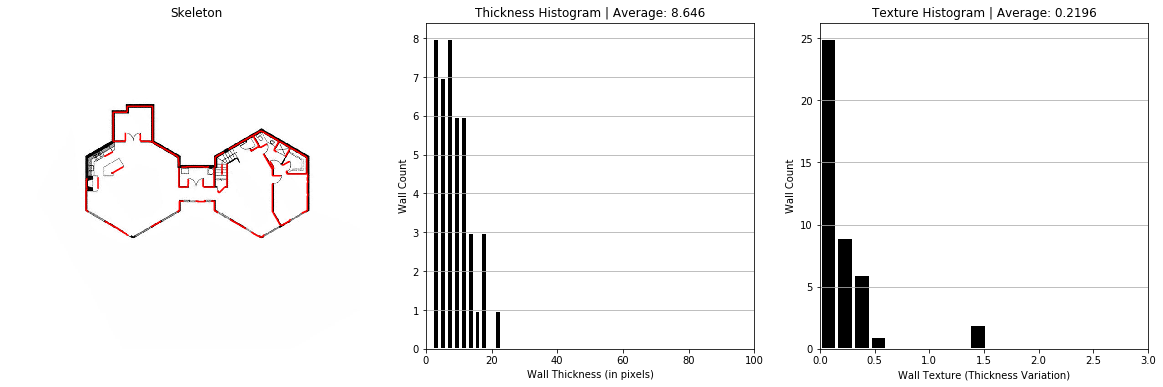

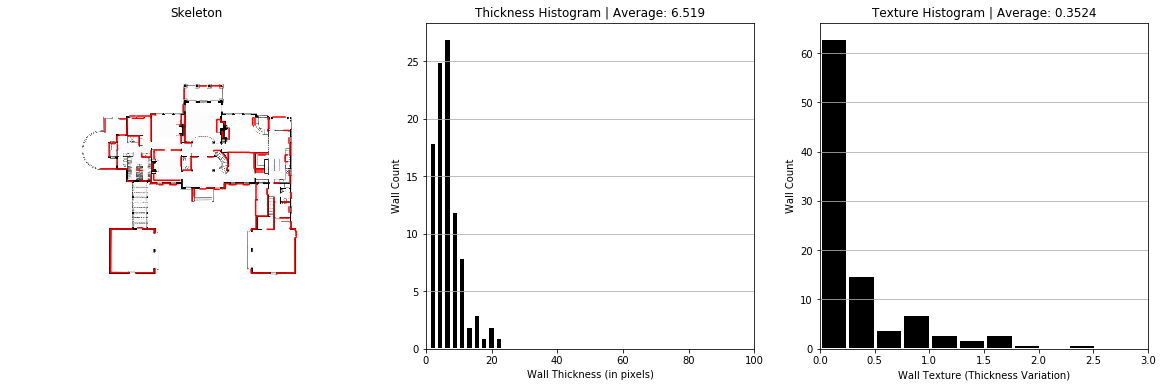

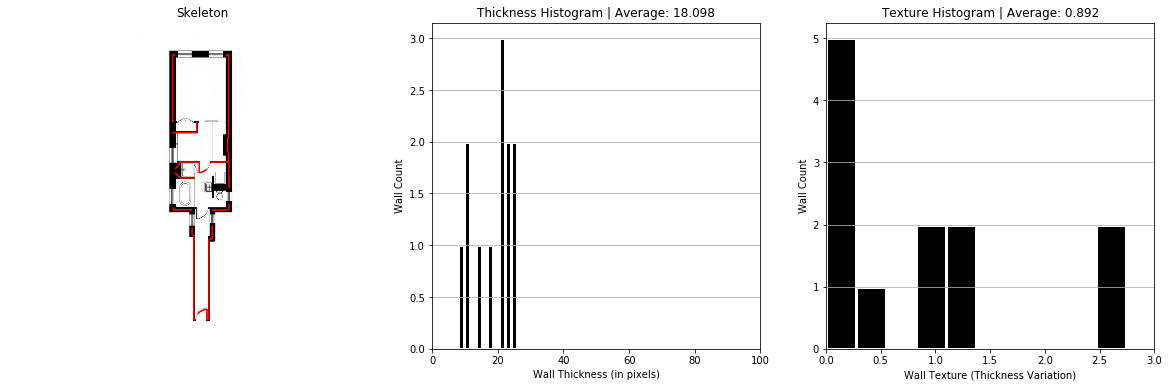

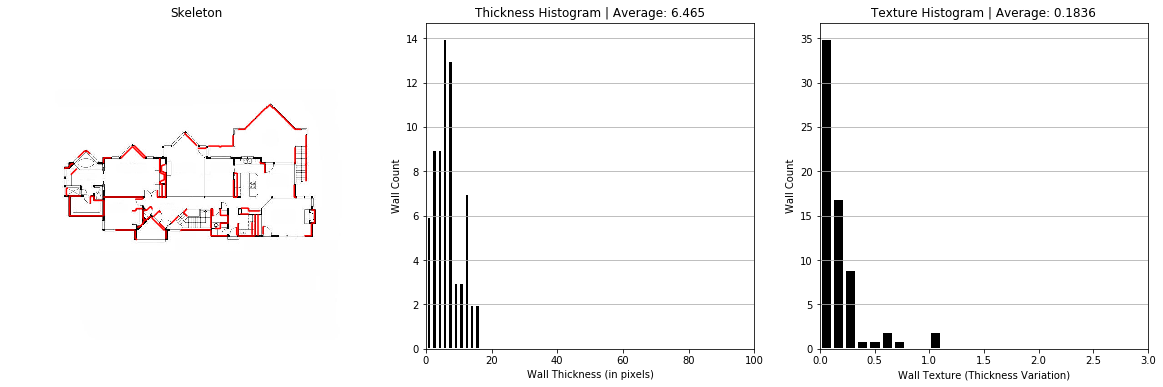

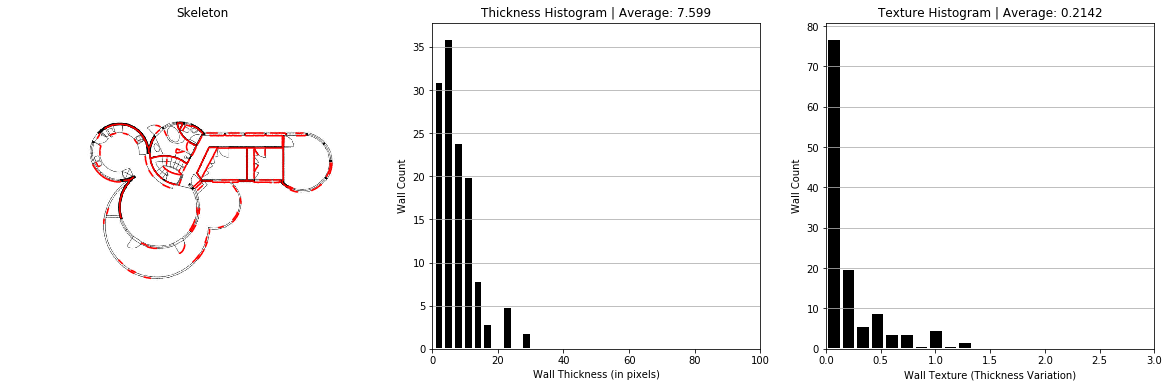

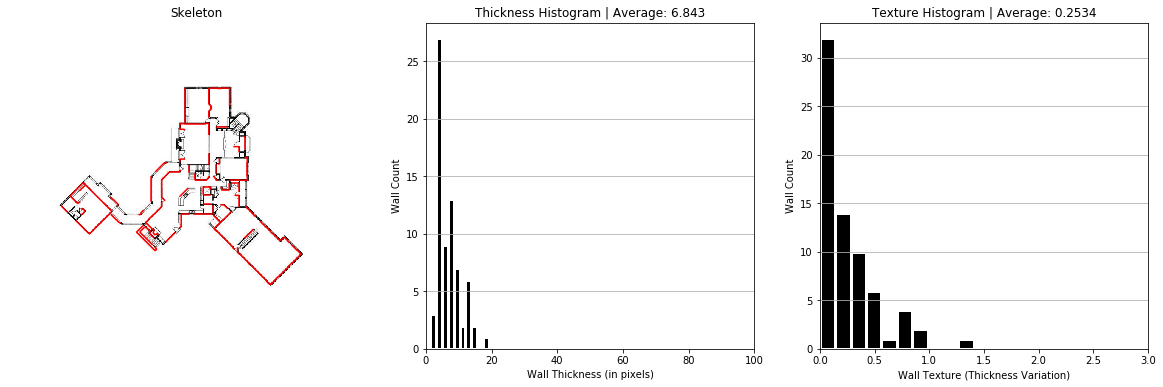

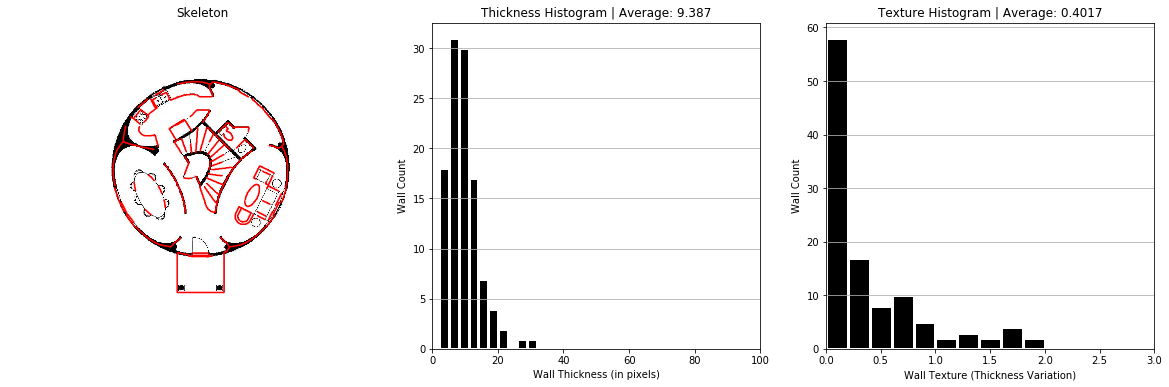

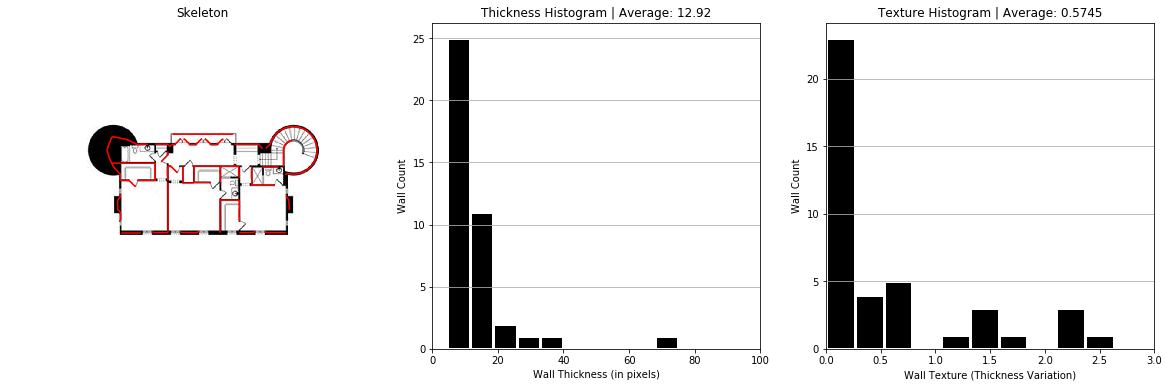

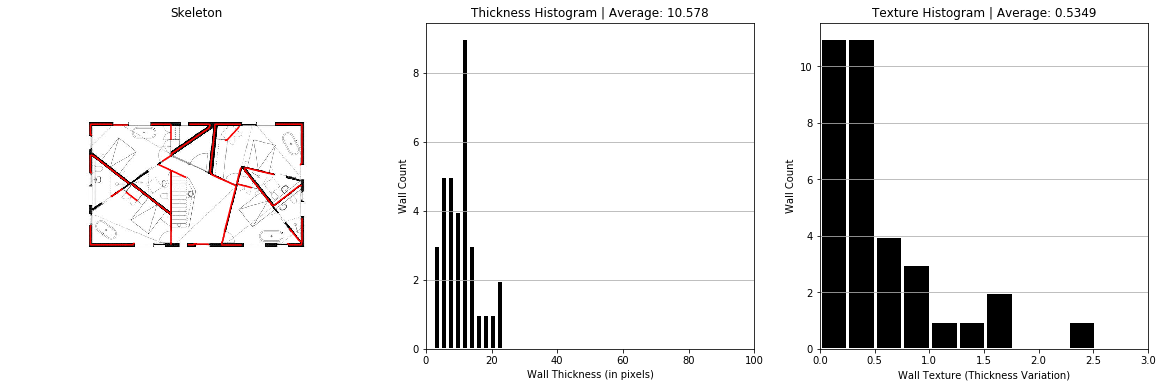

In [13]:
img_names = os.listdir("IMG/terrible_plans")
img_path = "IMG/terrible_plans/"+img_names[0]

for i in range(25):
    img_path = "IMG/terrible_plans/"+img_names[i]
    get_thickness_texture(img_path)